# Import

In [1]:
import pandas as pd
import numpy as np
import math
import tqdm as tq


import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')
# Plots
# ==============================================================================
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')

# Modelling and Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# 패키지
from xgboost import XGBRegressor
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb
from ngboost import NGBRegressor

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
import math 

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from itertools import *
from IPython.display import clear_output

In [2]:
# 평가지표 MAPE 확인용 함수 생성 
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred= np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred) / y_true)) * 100

# 데이터 불러오기
data = pd.read_csv("Assignment Material.csv")
data.head()

,Date,Month,Day,Weekday,IV01,IV02,IV03,IV04,IV05,IV06,...,IV16,IV17,IV18,IV19,IV20,IV21,IV22,IV23,IV24,Power
0,2009-01-02,1,2,5,0.5,0.866025,0.394356,0.918958,-0.433884,-0.900969,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,45.5
1,2009-01-03,1,3,6,0.5,0.866025,0.571268,0.820763,-0.974928,-0.222521,...,0.0,0,0.0,0,0.0,0,0.0,0,45.5,70.9
2,2009-01-04,1,4,7,0.5,0.866025,0.724793,0.688967,-0.781831,0.623490,...,0.0,0,0.0,0,0.0,0,45.5,1,70.9,73.2
3,2009-01-05,1,5,1,0.5,0.866025,0.848644,0.528964,0.000000,1.000000,...,0.0,0,0.0,0,45.5,1,70.9,1,73.2,71.6
4,2009-01-06,1,6,2,0.5,0.866025,0.937752,0.347305,0.781831,0.623490,...,0.0,0,45.5,1,70.9,1,73.2,0,71.6,58.6


# 시각화

In [4]:
train_data= data.iloc[7:729, :]
test_data= data.iloc[729:, :]# 2011년

In [5]:
train_data.head()

,Date,Month,Day,Weekday,IV01,IV02,IV03,IV04,IV05,IV06,...,IV16,IV17,IV18,IV19,IV20,IV21,IV22,IV23,IV24,Power
7,2009-01-09,1,9,5,0.5,0.866025,0.968077,-0.250653,-0.433884,-0.900969,...,73.2,0,71.6,0,58.6,0,53.7,0,56.2,54.1
8,2009-01-10,1,10,6,0.5,0.866025,0.897805,-0.440394,-0.974928,-0.222521,...,71.6,0,58.6,0,53.7,0,56.2,0,54.1,38.5
9,2009-01-11,1,11,7,0.5,0.866025,0.790776,-0.612106,-0.781831,0.623490,...,58.6,0,53.7,0,56.2,0,54.1,1,38.5,39.2
10,2009-01-12,1,12,1,0.5,0.866025,0.651372,-0.758758,0.000000,1.000000,...,53.7,0,56.2,0,54.1,1,38.5,1,39.2,55.4
11,2009-01-13,1,13,2,0.5,0.866025,0.485302,-0.874347,0.781831,0.623490,...,56.2,0,54.1,1,38.5,1,39.2,0,55.4,52.8


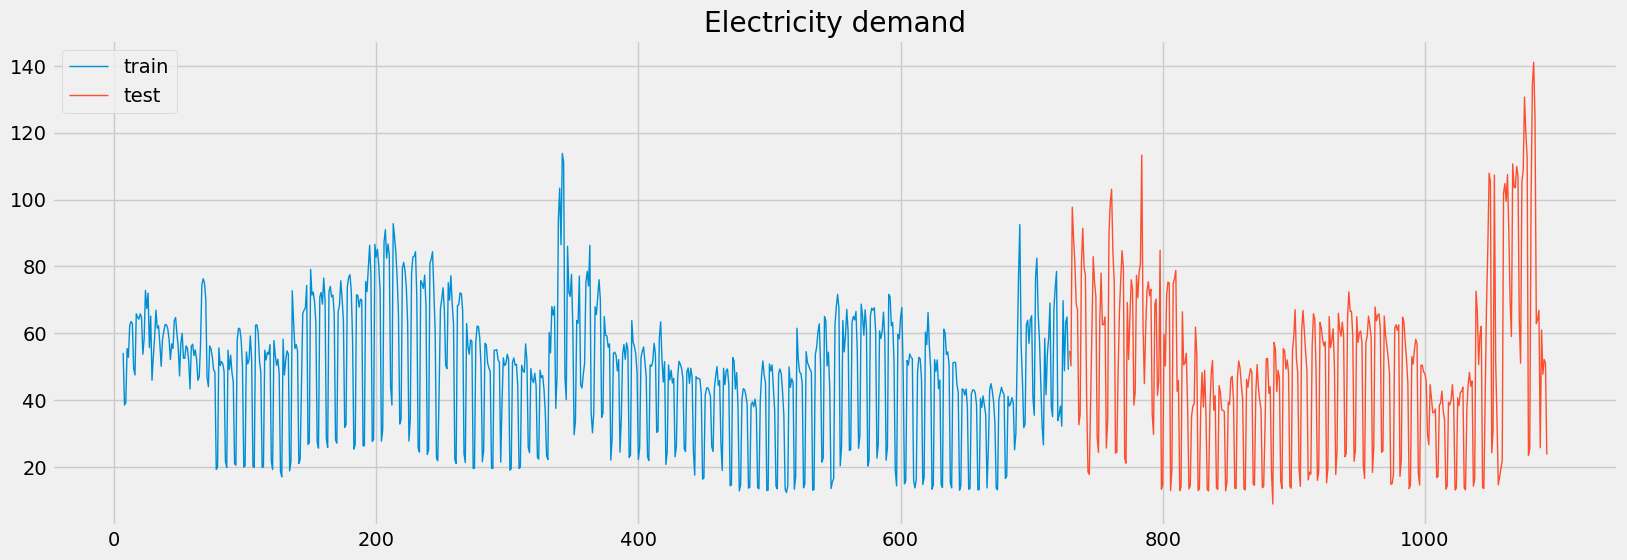

In [6]:
# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(18, 6))
train_data.Power.plot(ax=ax, label='train', linewidth=1)
test_data.Power.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Electricity demand')
ax.legend();

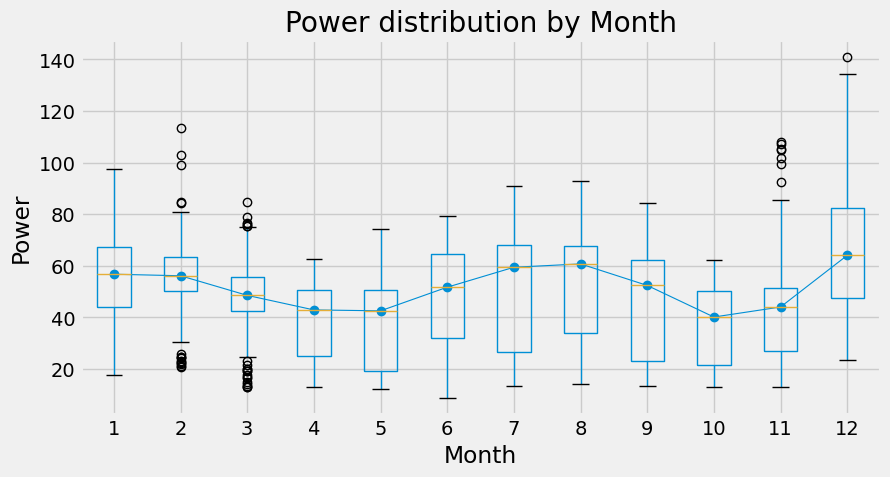

In [7]:
# Boxplot for annual seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 5))
data.boxplot(column='Power', by='Month', ax=ax,)
data.groupby('Month')['Power'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Power')
ax.set_title('Power distribution by Month')
fig.suptitle('');

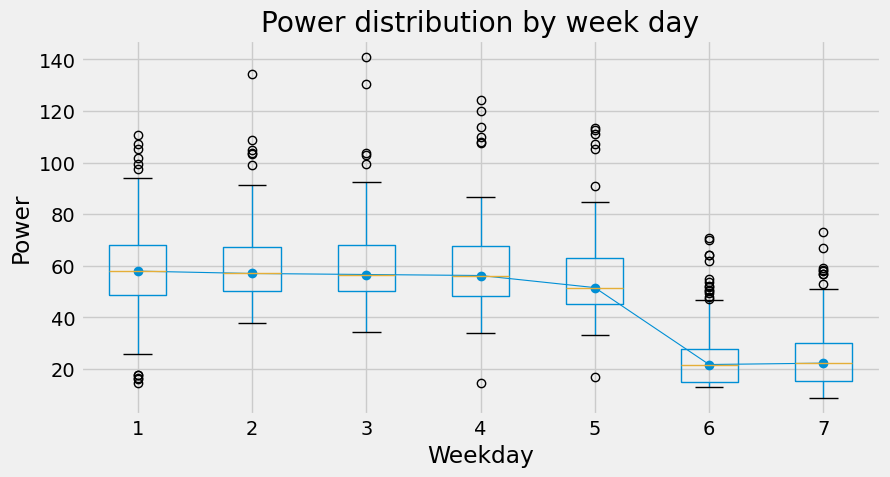

In [8]:
# Boxplot for weekly seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 5))
data.boxplot(column='Power', by='Weekday', ax=ax)
data.groupby('Weekday')['Power'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Power')
ax.set_title('Power distribution by week day')
fig.suptitle('');

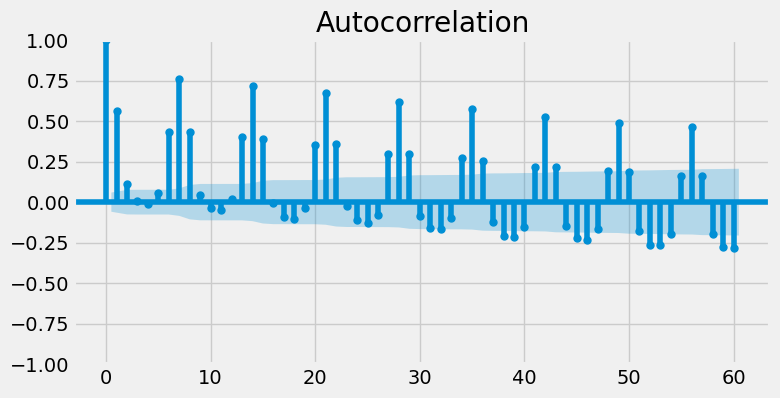

In [9]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 4))
plot_acf(data.Power, ax=ax, lags=60)
plt.show()

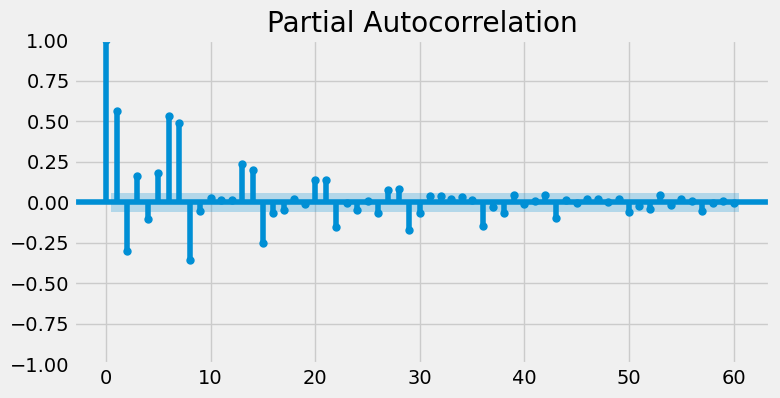

In [10]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 4))
plot_pacf(data.Power, ax=ax, lags=60)
plt.show()

# 파생 feature 추가

In [11]:
train_data= data.iloc[7:729, :]
test_data= data.iloc[729:, :]# 2011년

In [12]:
""" ## 주별 발전량 평균 넣어주기
power_Weekday_mean = pd.pivot_table(data, values = 'Power', index = ['Weekday'], aggfunc = np.mean).reset_index()
tqdm.pandas()
data['Weekday_mean'] = data.progress_apply(lambda x : power_Weekday_mean.loc[(power_Weekday_mean.Weekday == x['Weekday']) ,'Power'].values[0], axis = 1)

## 주별 발전량 표준편차 넣어주기
power_Weekday_std = pd.pivot_table(data, values = 'Power', index = ['Weekday'], aggfunc = np.std).reset_index()
tqdm.pandas()
data['Weekday_std'] = data.progress_apply(lambda x : power_Weekday_std.loc[(power_Weekday_std.Weekday == x['Weekday']) ,'Power'].values[0], axis = 1)

## 월별 발전량 평균 넣어주기
power_Month_mean = pd.pivot_table(data, values = 'Power', index = ['Month'], aggfunc = np.mean).reset_index()
tqdm.pandas()
data['Month_mean'] = data.progress_apply(lambda x : power_Month_mean.loc[(power_Month_mean.Month == x['Month']) ,'Power'].values[0], axis = 1)

## 월별 발전량 표준편차 넣어주기
power_Month_std = pd.pivot_table(data, values = 'Power', index = ['Month'], aggfunc = np.std).reset_index()
tqdm.pandas()
data['Month_std'] = data.progress_apply(lambda x : power_Month_std.loc[(power_Month_std.Month == x['Month']) ,'Power'].values[0], axis = 1) """

" ## 주별 발전량 평균 넣어주기\npower_Weekday_mean = pd.pivot_table(data, values = 'Power', index = ['Weekday'], aggfunc = np.mean).reset_index()\ntqdm.pandas()\ndata['Weekday_mean'] = data.progress_apply(lambda x : power_Weekday_mean.loc[(power_Weekday_mean.Weekday == x['Weekday']) ,'Power'].values[0], axis = 1)\n\n## 주별 발전량 표준편차 넣어주기\npower_Weekday_std = pd.pivot_table(data, values = 'Power', index = ['Weekday'], aggfunc = np.std).reset_index()\ntqdm.pandas()\ndata['Weekday_std'] = data.progress_apply(lambda x : power_Weekday_std.loc[(power_Weekday_std.Weekday == x['Weekday']) ,'Power'].values[0], axis = 1)\n\n## 월별 발전량 평균 넣어주기\npower_Month_mean = pd.pivot_table(data, values = 'Power', index = ['Month'], aggfunc = np.mean).reset_index()\ntqdm.pandas()\ndata['Month_mean'] = data.progress_apply(lambda x : power_Month_mean.loc[(power_Month_mean.Month == x['Month']) ,'Power'].values[0], axis = 1)\n\n## 월별 발전량 표준편차 넣어주기\npower_Month_std = pd.pivot_table(data, values = 'Power', index = ['Month'], agg

In [13]:
""" ## 시간의 순환성을 고려해준 컬럼 추가
data['sin_Weekday'] = np.sin(2*np.pi*data.Weekday/7)
data['cos_Weekday'] = np.cos(2*np.pi*data.Weekday/7)

data['sin_Month'] = np.sin(2*np.pi*data.Month/30)
data['cos_Month'] = np.cos(2*np.pi*data.Month/30) """

" ## 시간의 순환성을 고려해준 컬럼 추가\ndata['sin_Weekday'] = np.sin(2*np.pi*data.Weekday/7)\ndata['cos_Weekday'] = np.cos(2*np.pi*data.Weekday/7)\n\ndata['sin_Month'] = np.sin(2*np.pi*data.Month/30)\ndata['cos_Month'] = np.cos(2*np.pi*data.Month/30) "

In [14]:
train_data= data.iloc[7:729, 0:52]# 2009년부터2010년까지
train_data.head(5)

test_data= data.iloc[729:, 0:52]# 2011년
test_data.head(5)

,Date,Month,Day,Weekday,IV01,IV02,IV03,IV04,IV05,IV06,...,IV16,IV17,IV18,IV19,IV20,IV21,IV22,IV23,IV24,Power
729,2011-01-01,1,1,6,0.5,0.866025,0.201299,0.979530,-0.974928,-0.222521,...,69.72,0,48.75,0,63.28,0,64.86,1,49.07,54.7
730,2011-01-02,1,2,7,0.5,0.866025,0.394356,0.918958,-0.781831,0.623490,...,48.75,0,63.28,0,64.86,1,49.07,1,54.70,50.2
731,2011-01-03,1,3,1,0.5,0.866025,0.571268,0.820763,0.000000,1.000000,...,63.28,0,64.86,1,49.07,1,54.70,1,50.20,97.7
732,2011-01-04,1,4,2,0.5,0.866025,0.724793,0.688967,0.781831,0.623490,...,64.86,1,49.07,1,54.70,1,50.20,0,97.70,88.5
733,2011-01-05,1,5,3,0.5,0.866025,0.848644,0.528964,0.974928,-0.222521,...,49.07,1,54.70,1,50.20,0,97.70,0,88.50,80.9


In [15]:
# 평가지표 MAPE 확인용 함수 생성 
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred= np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred) / y_true)) * 100

# 데이터 불러오기
data = pd.read_csv("Assignment Material.csv")
data.head()

,Date,Month,Day,Weekday,IV01,IV02,IV03,IV04,IV05,IV06,...,IV16,IV17,IV18,IV19,IV20,IV21,IV22,IV23,IV24,Power
0,2009-01-02,1,2,5,0.5,0.866025,0.394356,0.918958,-0.433884,-0.900969,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,45.5
1,2009-01-03,1,3,6,0.5,0.866025,0.571268,0.820763,-0.974928,-0.222521,...,0.0,0,0.0,0,0.0,0,0.0,0,45.5,70.9
2,2009-01-04,1,4,7,0.5,0.866025,0.724793,0.688967,-0.781831,0.623490,...,0.0,0,0.0,0,0.0,0,45.5,1,70.9,73.2
3,2009-01-05,1,5,1,0.5,0.866025,0.848644,0.528964,0.000000,1.000000,...,0.0,0,0.0,0,45.5,1,70.9,1,73.2,71.6
4,2009-01-06,1,6,2,0.5,0.866025,0.937752,0.347305,0.781831,0.623490,...,0.0,0,45.5,1,70.9,1,73.2,0,71.6,58.6


In [16]:
train_data= data.iloc[7:729, 0:52]# 2009년부터2010년까지
train_data.head(5)

test_data= data.iloc[729:, 0:52]# 2011년
test_data.head(5)

,Date,Month,Day,Weekday,IV01,IV02,IV03,IV04,IV05,IV06,...,IV16,IV17,IV18,IV19,IV20,IV21,IV22,IV23,IV24,Power
729,2011-01-01,1,1,6,0.5,0.866025,0.201299,0.979530,-0.974928,-0.222521,...,69.72,0,48.75,0,63.28,0,64.86,1,49.07,54.7
730,2011-01-02,1,2,7,0.5,0.866025,0.394356,0.918958,-0.781831,0.623490,...,48.75,0,63.28,0,64.86,1,49.07,1,54.70,50.2
731,2011-01-03,1,3,1,0.5,0.866025,0.571268,0.820763,0.000000,1.000000,...,63.28,0,64.86,1,49.07,1,54.70,1,50.20,97.7
732,2011-01-04,1,4,2,0.5,0.866025,0.724793,0.688967,0.781831,0.623490,...,64.86,1,49.07,1,54.70,1,50.20,0,97.70,88.5
733,2011-01-05,1,5,3,0.5,0.866025,0.848644,0.528964,0.974928,-0.222521,...,49.07,1,54.70,1,50.20,0,97.70,0,88.50,80.9


In [17]:
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

In [18]:
from tqdm import tqdm
import time

train_data = train_data.sort_values(["Weekday", "Date"])
test_data = test_data.sort_values(["Weekday", "Date"])
Y_test = test_data.Power

xgb_pred = []
pred_0 =[]
pred_1 =[]
pred_2 =[]
pred_3 =[]
pred_4 =[]
pred_5 =[]
pred_6 =[]

robust = []
robust_Y_test = []

mape_list =[]

for i in tqdm(range(7)):
    X_Data_mushine= train_data.loc[train_data.Weekday == i+1, ].drop(["Date",'Month', 'Day', 'Weekday', 'Power'], axis=1)
    Y_Data_mushine= train_data.loc[train_data.Weekday == i+1, 'Power']
    X_Test_mushine= test_data.loc[test_data.Weekday == i+1, ].drop(["Date",'Month', 'Day', 'Weekday', 'Power'], axis=1)
    Y_Test_mushine= test_data.loc[test_data.Weekday == i+1, 'Power']
    
    xgb = XGBRegressor(random_state = 42)
    
    xgb.fit(X_Data_mushine, Y_Data_mushine)
    pred = xgb.predict(X_Test_mushine)
    score0 =  mean_absolute_percentage_error(Y_Test_mushine, pred)
    
    for j in [1, 3, 5, 7, 10, 25, 50, 75, 100]:
        xgb = XGBRegressor(random_state = 42)
        xgb.set_params(**{'objective' : weighted_mse(j)})
        xgb.fit(X_Data_mushine, Y_Data_mushine)
        pred = xgb.predict(X_Test_mushine)
        score1 =  mean_absolute_percentage_error(Y_Test_mushine, pred)
        if score1 < score0:
            best_alpha = j
            score0 = score1
    
    mape_list.append(score0)
    xgb_pred.extend(pred)  
    print("Weekday {} || best score : {} ".format(i+1, score0))
    
    # 요일 별 개별 저장
    if i == 0:
        pred_0.append(pred)
        robust.extend(pred)
        robust_Y_test.extend(Y_Test_mushine)
    elif i == 1:
        pred_1.append(pred)
        robust.extend(pred)
        robust_Y_test.extend(Y_Test_mushine)
    elif i == 2:
        pred_2.append(pred)
        robust.extend(pred)
        robust_Y_test.extend(Y_Test_mushine)
    elif i == 3:
        pred_3.append(pred)
        robust.extend(pred)
        robust_Y_test.extend(Y_Test_mushine)
    elif i == 4:
        pred_4.append(pred)
        robust.extend(pred)
        robust_Y_test.extend(Y_Test_mushine)
    elif i == 5: # 제일 약함
        pred_5.append(pred)
        robust.extend(pred)
        robust_Y_test.extend(Y_Test_mushine)
    elif i == 6:
        pred_6.append(pred)
        robust.extend(pred)
        robust_Y_test.extend(Y_Test_mushine)
            
print("주별 모델 생성 후 최종 점수:" ,mean_absolute_percentage_error(Y_test, xgb_pred))
print("토요일 제외 후 최종 점수:" ,mean_absolute_percentage_error(robust_Y_test, robust))

 14%|█▍        | 1/7 [00:01<00:08,  1.33s/it]

Weekday 1 || best score : 17.002706575669315 


 29%|██▊       | 2/7 [00:02<00:06,  1.31s/it]

Weekday 2 || best score : 11.024502371255545 


 43%|████▎     | 3/7 [00:03<00:05,  1.30s/it]

Weekday 3 || best score : 13.698665337900426 


 57%|█████▋    | 4/7 [00:05<00:03,  1.27s/it]

Weekday 4 || best score : 14.38317675459194 


 71%|███████▏  | 5/7 [00:06<00:02,  1.28s/it]

Weekday 5 || best score : 15.753865857555379 


 86%|████████▌ | 6/7 [00:07<00:01,  1.28s/it]

Weekday 6 || best score : 25.41655640038834 


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]

Weekday 7 || best score : 12.699444500676114 
주별 모델 생성 후 최종 점수: 17.2273595886821
토요일 제외 후 최종 점수: 17.2273595886821


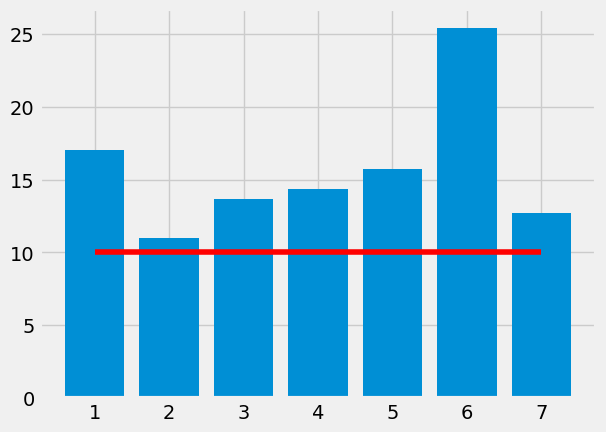

In [19]:
no_df = pd.DataFrame({'score':mape_list})
plt.bar(np.arange(len(no_df))+1, no_df['score'])
plt.plot([1,7], [10, 10], color = 'red')

# 월별 보다는 주별로 그룹을 나눠서 진행했을 때 더 성능이 좋았음

# 주 별로 나눠서 진행할때, xgb보다는 ngb가 0.5정도 더 좋은 성능을 보였음

# 파생 변수는 추가하면 오히려 성능이 낮아지므로 원데이터를 가지고 진행 할 예정

# 주 별 MLP 모델링

In [4]:
import pandas as pd

In [69]:
train_data= data.iloc[7:729, 0:]
test_data= data.iloc[729:, 0:]# 2011년

In [6]:
train_data = train_data.sort_values(["Weekday", "Date"])
test_data = test_data.sort_values(["Weekday", "Date"])
Y_test = test_data.Power

pred = []

In [7]:
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

# 월요일 MLP

In [59]:
X_Data = train_data.loc[train_data.Weekday == 1, ].drop(["Date",'Month', 'Day', 'Weekday', 'Power'], axis=1)
Y_Data = train_data.loc[train_data.Weekday == 1, 'Power']
X_Test = test_data.loc[test_data.Weekday == 1, ].drop(["Date",'Month', 'Day', 'Weekday', 'Power'], axis=1)
Y_Test = test_data.loc[test_data.Weekday == 1, 'Power']

scaler = StandardScaler().fit(X_Data)
X_Data= scaler.transform(X_Data)
X_Test= scaler.transform(X_Test)

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

from sklearn.metrics import mean_absolute_error
def objective(trial):
    param = {
        'learning_rate_init': trial.suggest_float('learning_rate_init', 0.0001, 0.1, step = 0.0001),
        'first_layer_neurons': trial.suggest_int('first_layer_neurons', 1, 40, step = 1),
        'second_layer_neurons': trial.suggest_int('second_layer_neurons', 1, 40, step = 1),
        'activation': trial.suggest_categorical('activation', ['identity', 'tanh', 'relu']),
        'max_iter' : trial.suggest_int('max_iter', 100, 2000, step = 10),
        'alpha' : trial.suggest_float('alpha', 0.0001, 0.001, step = 0.0001),
        'batch_size' : trial.suggest_float('batch_size', 5, 100, step = 1),
        'learning_rate' : trial.suggest_categorical('learning_rate',['constant', 'adaptive']),
        
        'eta' : trial.suggest_float('eta', 0.1, 1, step = 0.01),
        # 'num_boost_around' : trial.suggest_int('num_boost_around', 1, 30, step = 1),
        'max_depth' : trial.suggest_int('max_depth', 4, 16, step = 1),
        # 'sub_sample' : trial.suggest_float('sub_sample', 0.1, 1, step = 0.01),
        'objective' : weighted_mse()
    }

    model_MON = MLPRegressor(
        hidden_layer_sizes = (param['first_layer_neurons']),
        learning_rate_init = param['learning_rate_init'],
        activation = param['activation'],
        random_state = 42,
        max_iter = param['max_iter'],
        learning_rate = param['learning_rate']
    )
    model_MON.fit(X_Data, Y_Data.values.ravel())
    mlp_pred_MON = model_MON.predict(X_Test)

    return mean_absolute_percentage_error(Y_Test, mlp_pred_MON)

In [60]:
study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 5000)

clear_output()

In [61]:
# 월요일 결과 저장
MON_hyper = study.trials_dataframe().sort_values(["value"]).head(1)
MON_hyper
MON_hyper.to_csv("MON_hyper.csv", index=False, encoding="utf-8-sig")

In [62]:
# 최적 파라미터 적용
model_MON = MLPRegressor(
        hidden_layer_sizes = study.trials_dataframe().sort_values(["value"]).params_first_layer_neurons.iloc[0],
        learning_rate_init = study.trials_dataframe().sort_values(["value"]).params_learning_rate_init.iloc[0],
        activation = study.trials_dataframe().sort_values(["value"]).params_activation.iloc[0],
        random_state = 42,
        max_iter = study.trials_dataframe().sort_values(["value"]).params_max_iter	.iloc[0],
        learning_rate = study.trials_dataframe().sort_values(["value"]).params_learning_rate.iloc[0]
    ).fit(X_Data, Y_Data.values.ravel())

mlp_pred_MON = model_MON.predict(X_Test)

print( "MLP Score: ", mean_absolute_percentage_error(Y_Test, mlp_pred_MON))
pred.extend(mlp_pred_MON)

MLP Score:  15.061897590520454


# 화요일 MLP

In [63]:
X_Data = train_data.loc[train_data.Weekday == 2, ].drop(["Date",'Month', 'Day', 'Weekday', 'Power'], axis=1)
Y_Data = train_data.loc[train_data.Weekday == 2, 'Power']
X_Test = test_data.loc[test_data.Weekday == 2, ].drop(["Date",'Month', 'Day', 'Weekday', 'Power'], axis=1)
Y_Test = test_data.loc[test_data.Weekday == 2, 'Power']

scaler = StandardScaler().fit(X_Data)
X_Data= scaler.transform(X_Data)
X_Test= scaler.transform(X_Test)

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

from sklearn.metrics import mean_absolute_error
def objective(trial):
    param = {
        'learning_rate_init': trial.suggest_float('learning_rate_init', 0.0001, 0.1, step = 0.0001),
        'first_layer_neurons': trial.suggest_int('first_layer_neurons', 1, 40, step = 1),
        'second_layer_neurons': trial.suggest_int('second_layer_neurons', 1, 40, step = 1),
        'activation': trial.suggest_categorical('activation', ['identity', 'tanh', 'relu']),
        'max_iter' : trial.suggest_int('max_iter', 100, 2000, step = 10),
        'alpha' : trial.suggest_float('alpha', 0.0001, 0.001, step = 0.0001),
        'batch_size' : trial.suggest_float('batch_size', 5, 100, step = 1),
        'learning_rate' : trial.suggest_categorical('learning_rate',['constant', 'adaptive']),
        
        'eta' : trial.suggest_float('eta', 0.1, 1, step = 0.01),
        # 'num_boost_around' : trial.suggest_int('num_boost_around', 1, 30, step = 1),
        'max_depth' : trial.suggest_int('max_depth', 4, 16, step = 1),
        # 'sub_sample' : trial.suggest_float('sub_sample', 0.1, 1, step = 0.01),
        'objective' : weighted_mse()
    }

    model_TUE = MLPRegressor(
        hidden_layer_sizes = (param['first_layer_neurons']),
        learning_rate_init = param['learning_rate_init'],
        activation = param['activation'],
        random_state = 42,
        max_iter = param['max_iter'],
        learning_rate = param['learning_rate']
    )
    model_TUE.fit(X_Data, Y_Data.values.ravel())
    mlp_pred_TUE = model_TUE.predict(X_Test)

    return mean_absolute_percentage_error(Y_Test, mlp_pred_TUE)

In [64]:
study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 5000)

clear_output()

In [65]:
# 화요일 결과 저장
TUE_hyper = study.trials_dataframe().sort_values(["value"]).head(1)
print(TUE_hyper)
TUE_hyper.to_csv("TUE_hyper.csv", index=False, encoding="utf-8-sig")

      number     value             datetime_start          datetime_complete  \
2426    2426  9.139003 2022-11-24 08:10:45.851817 2022-11-24 08:10:46.115817   

                   duration params_activation  params_alpha  \
2426 0 days 00:00:00.264000              relu        0.0001   

      params_batch_size  params_eta  params_first_layer_neurons  \
2426               63.0        0.89                          22   

     params_learning_rate  params_learning_rate_init  params_max_depth  \
2426             adaptive                     0.0168                15   

      params_max_iter  params_second_layer_neurons     state  
2426              940                           36  COMPLETE  


In [66]:
# 최적 파라미터 적용
model_TUE = MLPRegressor(
        hidden_layer_sizes = study.trials_dataframe().sort_values(["value"]).params_first_layer_neurons.iloc[0],
        learning_rate_init = study.trials_dataframe().sort_values(["value"]).params_learning_rate_init.iloc[0],
        activation = study.trials_dataframe().sort_values(["value"]).params_activation.iloc[0],
        random_state = 42,
        max_iter = study.trials_dataframe().sort_values(["value"]).params_max_iter	.iloc[0],
        learning_rate = study.trials_dataframe().sort_values(["value"]).params_learning_rate.iloc[0]
    ).fit(X_Data, Y_Data.values.ravel())

mlp_pred_TUE = model_TUE.predict(X_Test)

print( "MLP Score: ", mean_absolute_percentage_error(Y_Test, mlp_pred_TUE))
pred.extend(mlp_pred_TUE)

MLP Score:  9.13900304704747


# 수요일 MLP

In [67]:
X_Data = train_data.loc[train_data.Weekday == 3, ].drop(["Date",'Month', 'Day', 'Weekday', 'Power'], axis=1)
Y_Data = train_data.loc[train_data.Weekday == 3, 'Power']
X_Test = test_data.loc[test_data.Weekday == 3, ].drop(["Date",'Month', 'Day', 'Weekday', 'Power'], axis=1)
Y_Test = test_data.loc[test_data.Weekday == 3, 'Power']

scaler = StandardScaler().fit(X_Data)
X_Data= scaler.transform(X_Data)
X_Test= scaler.transform(X_Test)

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

from sklearn.metrics import mean_absolute_error
def objective(trial):
    param = {
        'learning_rate_init': trial.suggest_float('learning_rate_init', 0.0001, 0.1, step = 0.0001),
        'first_layer_neurons': trial.suggest_int('first_layer_neurons', 1, 40, step = 1),
        'second_layer_neurons': trial.suggest_int('second_layer_neurons', 1, 40, step = 1),
        'activation': trial.suggest_categorical('activation', ['identity', 'tanh', 'relu']),
        'max_iter' : trial.suggest_int('max_iter', 100, 2000, step = 10),
        'alpha' : trial.suggest_float('alpha', 0.0001, 0.001, step = 0.0001),
        'batch_size' : trial.suggest_float('batch_size', 5, 100, step = 1),
        'learning_rate' : trial.suggest_categorical('learning_rate',['constant', 'adaptive']),
        
        'eta' : trial.suggest_float('eta', 0.1, 1, step = 0.01),
        # 'num_boost_around' : trial.suggest_int('num_boost_around', 1, 30, step = 1),
        'max_depth' : trial.suggest_int('max_depth', 4, 16, step = 1),
        # 'sub_sample' : trial.suggest_float('sub_sample', 0.1, 1, step = 0.01),
        'objective' : weighted_mse()
    }

    model_WED = MLPRegressor(
        hidden_layer_sizes = (param['first_layer_neurons']),
        learning_rate_init = param['learning_rate_init'],
        activation = param['activation'],
        random_state = 42,
        max_iter = param['max_iter'],
        learning_rate = param['learning_rate']
    )
    model_WED.fit(X_Data, Y_Data.values.ravel())
    mlp_pred_WED = model_WED.predict(X_Test)

    return mean_absolute_percentage_error(Y_Test, mlp_pred_WED)

In [68]:
study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 5000)

clear_output()

In [69]:
# 수요일 결과 저장
WED_hyper = study.trials_dataframe().sort_values(["value"]).head(1)
print(WED_hyper)
WED_hyper.to_csv("WED_hyper.csv", index=False, encoding="utf-8-sig")

      number      value             datetime_start          datetime_complete  \
3657    3657  11.505911 2022-11-24 08:40:36.073060 2022-11-24 08:40:36.395060   

                   duration params_activation  params_alpha  \
3657 0 days 00:00:00.322000              relu        0.0002   

      params_batch_size  params_eta  params_first_layer_neurons  \
3657               15.0         0.9                           4   

     params_learning_rate  params_learning_rate_init  params_max_depth  \
3657             adaptive                      0.025                16   

      params_max_iter  params_second_layer_neurons     state  
3657              500                           28  COMPLETE  


In [70]:
# 최적 파라미터 적용
model_WED = MLPRegressor(
        hidden_layer_sizes = study.trials_dataframe().sort_values(["value"]).params_first_layer_neurons.iloc[0],
        learning_rate_init = study.trials_dataframe().sort_values(["value"]).params_learning_rate_init.iloc[0],
        activation = study.trials_dataframe().sort_values(["value"]).params_activation.iloc[0],
        random_state = 42,
        max_iter = study.trials_dataframe().sort_values(["value"]).params_max_iter	.iloc[0],
        learning_rate = study.trials_dataframe().sort_values(["value"]).params_learning_rate.iloc[0]
    ).fit(X_Data, Y_Data.values.ravel())

mlp_pred_WED = model_WED.predict(X_Test)

print( "MLP Score: ", mean_absolute_percentage_error(Y_Test, mlp_pred_WED))
pred.extend(mlp_pred_WED)

MLP Score:  11.505910827216185


# 목요일 MLP

In [36]:
X_Data = train_data.loc[train_data.Weekday == 4, ].drop(["Date",'Month', 'Day', 'Weekday', 'Power'], axis=1)
Y_Data = train_data.loc[train_data.Weekday == 4, 'Power']
X_Test = test_data.loc[test_data.Weekday == 4, ].drop(["Date",'Month', 'Day', 'Weekday', 'Power'], axis=1)
Y_Test = test_data.loc[test_data.Weekday == 4, 'Power']

scaler = StandardScaler().fit(X_Data)
X_Data= scaler.transform(X_Data)
X_Test= scaler.transform(X_Test)

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

from sklearn.metrics import mean_absolute_error
def objective(trial):
    param = {
        'learning_rate_init': trial.suggest_float('learning_rate_init', 0.0001, 0.1, step = 0.0001),
        'first_layer_neurons': trial.suggest_int('first_layer_neurons', 1, 40, step = 1),
        'second_layer_neurons': trial.suggest_int('second_layer_neurons', 1, 40, step = 1),
        'activation': trial.suggest_categorical('activation', ['identity', 'tanh', 'relu']),
        'max_iter' : trial.suggest_int('max_iter', 100, 2000, step = 10),
        'alpha' : trial.suggest_float('alpha', 0.0001, 0.001, step = 0.0001),
        'batch_size' : trial.suggest_float('batch_size', 5, 100, step = 1),
        'learning_rate' : trial.suggest_categorical('learning_rate',['constant', 'adaptive']),
        
        'eta' : trial.suggest_float('eta', 0.1, 1, step = 0.01),
        # 'num_boost_around' : trial.suggest_int('num_boost_around', 1, 30, step = 1),
        'max_depth' : trial.suggest_int('max_depth', 4, 16, step = 1),
        # 'sub_sample' : trial.suggest_float('sub_sample', 0.1, 1, step = 0.01),
        'objective' : weighted_mse()
    }

    model_THUR = MLPRegressor(
        hidden_layer_sizes = (param['first_layer_neurons']),
        learning_rate_init = param['learning_rate_init'],
        activation = param['activation'],
        random_state = 42,
        max_iter = param['max_iter'],
        learning_rate = param['learning_rate']
    )
    model_THUR.fit(X_Data, Y_Data.values.ravel())
    mlp_pred_THUR = model_THUR.predict(X_Test)

    return mean_absolute_percentage_error(Y_Test, mlp_pred_THUR)

In [37]:
study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 3000)

clear_output()

In [38]:
# 목요일 결과 저장
THUR_hyper = study.trials_dataframe().sort_values(["value"]).head(1)
print(THUR_hyper)
THUR_hyper.to_csv("THUR_hyper.csv", index=False, encoding="utf-8-sig")

     number     value             datetime_start          datetime_complete  \
735     735  9.865839 2022-11-24 13:24:17.055636 2022-11-24 13:24:17.261403   

                  duration params_activation  params_alpha  params_batch_size  \
735 0 days 00:00:00.205767              relu        0.0001               41.0   

     params_eta  params_first_layer_neurons params_learning_rate  \
735        0.67                          22             adaptive   

     params_learning_rate_init  params_max_depth  params_max_iter  \
735                     0.0478                 9              480   

     params_second_layer_neurons     state  
735                            7  COMPLETE  


In [39]:
# 최적 파라미터 적용
model_THUR = MLPRegressor(
        hidden_layer_sizes = study.trials_dataframe().sort_values(["value"]).params_first_layer_neurons.iloc[0],
        learning_rate_init = study.trials_dataframe().sort_values(["value"]).params_learning_rate_init.iloc[0],
        activation = study.trials_dataframe().sort_values(["value"]).params_activation.iloc[0],
        random_state = 42,
        max_iter = study.trials_dataframe().sort_values(["value"]).params_max_iter	.iloc[0],
        learning_rate = study.trials_dataframe().sort_values(["value"]).params_learning_rate.iloc[0]
    ).fit(X_Data, Y_Data.values.ravel())

mlp_pred_THUR = model_THUR.predict(X_Test)

print( "MLP Score: ", mean_absolute_percentage_error(Y_Test, mlp_pred_THUR))
pred.extend(mlp_pred_THUR)

MLP Score:  9.865839007473086


# 금요일 MLP

In [75]:
X_Data = train_data.loc[train_data.Weekday == 5, ].drop(["Date",'Month', 'Day', 'Weekday', 'Power'], axis=1)
Y_Data = train_data.loc[train_data.Weekday == 5, 'Power']
X_Test = test_data.loc[test_data.Weekday == 5, ].drop(["Date",'Month', 'Day', 'Weekday', 'Power'], axis=1)
Y_Test = test_data.loc[test_data.Weekday == 5, 'Power']

scaler = StandardScaler().fit(X_Data)
X_Data= scaler.transform(X_Data)
X_Test= scaler.transform(X_Test)

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

from sklearn.metrics import mean_absolute_error
def objective(trial):
    param = {
        'learning_rate_init': trial.suggest_float('learning_rate_init', 0.0001, 0.1, step = 0.0001),
        'first_layer_neurons': trial.suggest_int('first_layer_neurons', 1, 40, step = 1),
        'second_layer_neurons': trial.suggest_int('second_layer_neurons', 1, 40, step = 1),
        'activation': trial.suggest_categorical('activation', ['identity', 'tanh', 'relu']),
        'max_iter' : trial.suggest_int('max_iter', 100, 2000, step = 10),
        'alpha' : trial.suggest_float('alpha', 0.0001, 0.001, step = 0.0001),
        'batch_size' : trial.suggest_float('batch_size', 5, 100, step = 1),
        'learning_rate' : trial.suggest_categorical('learning_rate',['constant', 'adaptive']),
        
        'eta' : trial.suggest_float('eta', 0.1, 1, step = 0.01),
        # 'num_boost_around' : trial.suggest_int('num_boost_around', 1, 30, step = 1),
        'max_depth' : trial.suggest_int('max_depth', 4, 16, step = 1),
        # 'sub_sample' : trial.suggest_float('sub_sample', 0.1, 1, step = 0.01),
        'objective' : weighted_mse()
    }

    model_FRI = MLPRegressor(
        hidden_layer_sizes = (param['first_layer_neurons']),
        learning_rate_init = param['learning_rate_init'],
        activation = param['activation'],
        random_state = 42,
        max_iter = param['max_iter'],
        learning_rate = param['learning_rate']
    )
    model_FRI.fit(X_Data, Y_Data.values.ravel())
    mlp_pred_FRI = model_FRI.predict(X_Test)

    return mean_absolute_percentage_error(Y_Test, mlp_pred_FRI)

In [76]:
study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 5000)

clear_output()

In [77]:
# 금요일 결과 저장
FRI_hyper = study.trials_dataframe().sort_values(["value"]).head(1)
print(FRI_hyper)
FRI_hyper.to_csv("FRI_hyper.csv", index=False, encoding="utf-8-sig")

      number     value             datetime_start          datetime_complete  \
4670    4670  10.94428 2022-11-24 09:32:43.352011 2022-11-24 09:32:43.802013   

                   duration params_activation  params_alpha  \
4670 0 days 00:00:00.450002              relu        0.0007   

      params_batch_size  params_eta  params_first_layer_neurons  \
4670               45.0        0.71                           4   

     params_learning_rate  params_learning_rate_init  params_max_depth  \
4670             adaptive                     0.0364                14   

      params_max_iter  params_second_layer_neurons     state  
4670             1080                            4  COMPLETE  


In [78]:
# 최적 파라미터 적용
model_FRI = MLPRegressor(
        hidden_layer_sizes = study.trials_dataframe().sort_values(["value"]).params_first_layer_neurons.iloc[0],
        learning_rate_init = study.trials_dataframe().sort_values(["value"]).params_learning_rate_init.iloc[0],
        activation = study.trials_dataframe().sort_values(["value"]).params_activation.iloc[0],
        random_state = 42,
        max_iter = study.trials_dataframe().sort_values(["value"]).params_max_iter	.iloc[0],
        learning_rate = study.trials_dataframe().sort_values(["value"]).params_learning_rate.iloc[0]
    ).fit(X_Data, Y_Data.values.ravel())

model_FRI = model_FRI.predict(X_Test)

print( "MLP Score: ", mean_absolute_percentage_error(Y_Test, model_FRI))
pred.extend(model_FRI)

MLP Score:  10.944280040174334


# 토요일 MLP

In [11]:
X_Data = train_data.loc[train_data.Weekday == 6, ].drop(["Date",'Month', 'Day', 'Weekday', 'Power'], axis=1)
Y_Data = train_data.loc[train_data.Weekday == 6, 'Power']
X_Test = test_data.loc[test_data.Weekday == 6, ].drop(["Date",'Month', 'Day', 'Weekday', 'Power'], axis=1)
Y_Test = test_data.loc[test_data.Weekday == 6, 'Power']

scaler = StandardScaler().fit(X_Data)
X_Data= scaler.transform(X_Data)
X_Test= scaler.transform(X_Test)

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

from sklearn.metrics import mean_absolute_error
def objective(trial):
    param = {
        'learning_rate_init': trial.suggest_float('learning_rate_init', 0.0001, 0.1, step = 0.0001),
        'first_layer_neurons': trial.suggest_int('first_layer_neurons', 1, 40, step = 1),
        'second_layer_neurons': trial.suggest_int('second_layer_neurons', 1, 40, step = 1),
        'activation': trial.suggest_categorical('activation', ['identity', 'tanh', 'relu']),
        'max_iter' : trial.suggest_int('max_iter', 100, 2000, step = 10),
        'alpha' : trial.suggest_float('alpha', 0.0001, 0.001, step = 0.0001),
        'batch_size' : trial.suggest_float('batch_size', 5, 100, step = 1),
        'learning_rate' : trial.suggest_categorical('learning_rate',['constant', 'adaptive']),
        
        'eta' : trial.suggest_float('eta', 0.1, 1, step = 0.01),
        # 'num_boost_around' : trial.suggest_int('num_boost_around', 1, 30, step = 1),
        'max_depth' : trial.suggest_int('max_depth', 4, 16, step = 1),
        # 'sub_sample' : trial.suggest_float('sub_sample', 0.1, 1, step = 0.01),
        'objective' : weighted_mse()
    }

    model_SAT = MLPRegressor(
        hidden_layer_sizes = (param['first_layer_neurons']),
        learning_rate_init = param['learning_rate_init'],
        activation = param['activation'],
        random_state = 42,
        max_iter = param['max_iter'],
        learning_rate = param['learning_rate']
    )
    model_SAT.fit(X_Data, Y_Data.values.ravel())
    mlp_pred_SAT = model_SAT.predict(X_Test)

    return mean_absolute_percentage_error(Y_Test, mlp_pred_SAT)

In [ ]:
study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 1000)

clear_output()

In [ ]:
# 토요일 결과 저장
SAT_hyper = study.trials_dataframe().sort_values(["value"]).head(1)
print(SAT_hyper)
SAT_hyper.to_csv("SAT_hyper.csv", index=False, encoding="utf-8-sig")

In [ ]:
# 최적 파라미터 적용
model_SAT = MLPRegressor(
        hidden_layer_sizes = study.trials_dataframe().sort_values(["value"]).params_first_layer_neurons.iloc[0],
        learning_rate_init = study.trials_dataframe().sort_values(["value"]).params_learning_rate_init.iloc[0],
        activation = study.trials_dataframe().sort_values(["value"]).params_activation.iloc[0],
        random_state = 42,
        max_iter = study.trials_dataframe().sort_values(["value"]).params_max_iter	.iloc[0],
        learning_rate = study.trials_dataframe().sort_values(["value"]).params_learning_rate.iloc[0]
    ).fit(X_Data, Y_Data.values.ravel())

mlp_pred_SAT = model_SAT.predict(X_Test)

print( "MLP Score: ", mean_absolute_percentage_error(Y_Test, mlp_pred_SAT))
pred.extend(mlp_pred_SAT)

MLP Score:  23.639104608257636


# 일요일 MLP

In [83]:
X_Data = train_data.loc[train_data.Weekday == 7, ].drop(["Date",'Month', 'Day', 'Weekday', 'Power'], axis=1)
Y_Data = train_data.loc[train_data.Weekday == 7, 'Power']
X_Test = test_data.loc[test_data.Weekday == 7, ].drop(["Date",'Month', 'Day', 'Weekday', 'Power'], axis=1)
Y_Test = test_data.loc[test_data.Weekday == 7, 'Power']

scaler = StandardScaler().fit(X_Data)
X_Data= scaler.transform(X_Data)
X_Test= scaler.transform(X_Test)

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

from sklearn.metrics import mean_absolute_error
def objective(trial):
    param = {
        'learning_rate_init': trial.suggest_float('learning_rate_init', 0.0001, 0.1, step = 0.0001),
        'first_layer_neurons': trial.suggest_int('first_layer_neurons', 1, 40, step = 1),
        'second_layer_neurons': trial.suggest_int('second_layer_neurons', 1, 40, step = 1),
        'activation': trial.suggest_categorical('activation', ['identity', 'tanh', 'relu']),
        'max_iter' : trial.suggest_int('max_iter', 100, 2000, step = 10),
        'alpha' : trial.suggest_float('alpha', 0.0001, 0.001, step = 0.0001),
        'batch_size' : trial.suggest_float('batch_size', 5, 100, step = 1),
        'learning_rate' : trial.suggest_categorical('learning_rate',['constant', 'adaptive']),
        
        'eta' : trial.suggest_float('eta', 0.1, 1, step = 0.01),
        # 'num_boost_around' : trial.suggest_int('num_boost_around', 1, 30, step = 1),
        'max_depth' : trial.suggest_int('max_depth', 4, 16, step = 1),
        # 'sub_sample' : trial.suggest_float('sub_sample', 0.1, 1, step = 0.01),
        'objective' : weighted_mse()
    }

    model_SUN = MLPRegressor(
        hidden_layer_sizes = (param['first_layer_neurons']),
        learning_rate_init = param['learning_rate_init'],
        activation = param['activation'],
        random_state = 42,
        max_iter = param['max_iter'],
        learning_rate = param['learning_rate']
    )
    model_SUN.fit(X_Data, Y_Data.values.ravel())
    mlp_pred_SUN = model_SUN.predict(X_Test)

    return mean_absolute_percentage_error(Y_Test, mlp_pred_SUN)

In [84]:
study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 5000)

clear_output()

In [85]:
# 일요일 결과 저장
SUN_hyper = study.trials_dataframe().sort_values(["value"]).head(1)
print(SUN_hyper)
SUN_hyper.to_csv("SUN_hyper.csv", index=False, encoding="utf-8-sig")

     number      value             datetime_start          datetime_complete  \
872     872  17.377892 2022-11-24 09:57:08.891475 2022-11-24 09:57:08.959476   

                  duration params_activation  params_alpha  params_batch_size  \
872 0 days 00:00:00.068001          identity        0.0001               68.0   

     params_eta  params_first_layer_neurons params_learning_rate  \
872        0.91                          18             adaptive   

     params_learning_rate_init  params_max_depth  params_max_iter  \
872                     0.0055                 6              210   

     params_second_layer_neurons     state  
872                            1  COMPLETE  


In [86]:
# 최적 파라미터 적용
model_SUN = MLPRegressor(
        hidden_layer_sizes = study.trials_dataframe().sort_values(["value"]).params_first_layer_neurons.iloc[0],
        learning_rate_init = study.trials_dataframe().sort_values(["value"]).params_learning_rate_init.iloc[0],
        activation = study.trials_dataframe().sort_values(["value"]).params_activation.iloc[0],
        random_state = 42,
        max_iter = study.trials_dataframe().sort_values(["value"]).params_max_iter	.iloc[0],
        learning_rate = study.trials_dataframe().sort_values(["value"]).params_learning_rate.iloc[0]
    ).fit(X_Data, Y_Data.values.ravel())

mlp_pred_SUN = model_SUN.predict(X_Test)

print( "MLP Score: ", mean_absolute_percentage_error(Y_Test, mlp_pred_SUN))
pred.extend(mlp_pred_SUN)

MLP Score:  17.377891712067555


# 주 별 MLP 결과 점수

In [87]:
print( "Final MLP Score: ", mean_absolute_percentage_error(test_data.Power, pred))

Final MLP Score:  14.074235471717989


# 위 과정을 요일별로 반복하여 원하는 mape임계값 도출을 해낸 뒤 최종 결과

# 1. Data and Function

In [27]:
# 평가지표 MAPE 확인용 함수 생성 
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred= np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred) / y_true)) * 100

# 데이터 불러오기
data = pd.read_csv("Assignment Material.csv")
data.head()

,Date,Month,Day,Weekday,IV01,IV02,IV03,IV04,IV05,IV06,...,IV16,IV17,IV18,IV19,IV20,IV21,IV22,IV23,IV24,Power
0,2009-01-02,1,2,5,0.5,0.866025,0.394356,0.918958,-0.433884,-0.900969,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,45.5
1,2009-01-03,1,3,6,0.5,0.866025,0.571268,0.820763,-0.974928,-0.222521,...,0.0,0,0.0,0,0.0,0,0.0,0,45.5,70.9
2,2009-01-04,1,4,7,0.5,0.866025,0.724793,0.688967,-0.781831,0.623490,...,0.0,0,0.0,0,0.0,0,45.5,1,70.9,73.2
3,2009-01-05,1,5,1,0.5,0.866025,0.848644,0.528964,0.000000,1.000000,...,0.0,0,0.0,0,45.5,1,70.9,1,73.2,71.6
4,2009-01-06,1,6,2,0.5,0.866025,0.937752,0.347305,0.781831,0.623490,...,0.0,0,45.5,1,70.9,1,73.2,0,71.6,58.6


In [28]:
train_data= data.iloc[7:729, 0:]
test_data= data.iloc[729:, 0:]# 2011년

In [29]:
train_data = train_data.sort_values(["Weekday", "Date"])
test_data = test_data.sort_values(["Weekday", "Date"])
Y_test = test_data.Power

pred = []

# 2. 요일 별 최적 파라미터에 맞춰 학습 및 결과

In [30]:
# 월요일
X_Data = train_data.loc[train_data.Weekday == 1, ].drop(["Date",'Month', 'Day', 'Weekday', 'Power'], axis=1)
Y_Data = train_data.loc[train_data.Weekday == 1, 'Power']
X_Test = test_data.loc[test_data.Weekday == 1, ].drop(["Date",'Month', 'Day', 'Weekday', 'Power'], axis=1)
Y_Test = test_data.loc[test_data.Weekday == 1, 'Power']

scaler = StandardScaler().fit(X_Data)
X_Data= scaler.transform(X_Data)
X_Test= scaler.transform(X_Test)

MON = pd.read_csv("MON_hyper.csv")

model_MON = MLPRegressor(
        hidden_layer_sizes = MON.params_first_layer_neurons.iloc[0],
        learning_rate_init = MON.params_learning_rate_init.iloc[0],
        activation = MON.params_activation.iloc[0],
        random_state = 42,
        max_iter = MON.params_max_iter	.iloc[0],
        learning_rate = MON.params_learning_rate.iloc[0]
    ).fit(X_Data, Y_Data.values.ravel())

mlp_pred_MON = model_MON.predict(X_Test)

print( "MLP Score: ", mean_absolute_percentage_error(Y_Test, mlp_pred_MON))
pred.extend(mlp_pred_MON)

MLP Score:  15.06189759052045


In [31]:
# 화요일
X_Data = train_data.loc[train_data.Weekday == 2, ].drop(["Date",'Month', 'Day', 'Weekday', 'Power'], axis=1)
Y_Data = train_data.loc[train_data.Weekday == 2, 'Power']
X_Test = test_data.loc[test_data.Weekday == 2, ].drop(["Date",'Month', 'Day', 'Weekday', 'Power'], axis=1)
Y_Test = test_data.loc[test_data.Weekday == 2, 'Power']

scaler = StandardScaler().fit(X_Data)
X_Data= scaler.transform(X_Data)
X_Test= scaler.transform(X_Test)

TUE = pd.read_csv("TUE_hyper.csv")

model_TUE = MLPRegressor(
        hidden_layer_sizes = TUE.params_first_layer_neurons.iloc[0],
        learning_rate_init = TUE.params_learning_rate_init.iloc[0],
        activation = TUE.params_activation.iloc[0],
        random_state = 42,
        max_iter = TUE.params_max_iter	.iloc[0],
        learning_rate = TUE.params_learning_rate.iloc[0]
    ).fit(X_Data, Y_Data.values.ravel())

mlp_pred_TUE = model_TUE.predict(X_Test)

print( "MLP Score: ", mean_absolute_percentage_error(Y_Test, mlp_pred_TUE))
pred.extend(mlp_pred_TUE)

MLP Score:  9.139003047047469


In [32]:
# 수요일
X_Data = train_data.loc[train_data.Weekday == 3, ].drop(["Date",'Month', 'Day', 'Weekday', 'Power'], axis=1)
Y_Data = train_data.loc[train_data.Weekday == 3, 'Power']
X_Test = test_data.loc[test_data.Weekday == 3, ].drop(["Date",'Month', 'Day', 'Weekday', 'Power'], axis=1)
Y_Test = test_data.loc[test_data.Weekday == 3, 'Power']

scaler = StandardScaler().fit(X_Data)
X_Data= scaler.transform(X_Data)
X_Test= scaler.transform(X_Test)

WED = pd.read_csv("WED_hyper.csv")

model_WED = MLPRegressor(
        hidden_layer_sizes = WED.params_first_layer_neurons.iloc[0],
        learning_rate_init = WED.params_learning_rate_init.iloc[0],
        activation = WED.params_activation.iloc[0],
        random_state = 42,
        max_iter = WED.params_max_iter	.iloc[0],
        learning_rate = WED.params_learning_rate.iloc[0]
    ).fit(X_Data, Y_Data.values.ravel())

mlp_pred_WED = model_WED.predict(X_Test)

print( "MLP Score: ", mean_absolute_percentage_error(Y_Test, mlp_pred_WED))
pred.extend(mlp_pred_WED)

MLP Score:  11.505910827216184


In [33]:
# 목요일
X_Data = train_data.loc[train_data.Weekday == 4, ].drop(["Date",'Month', 'Day', 'Weekday', 'Power'], axis=1)
Y_Data = train_data.loc[train_data.Weekday == 4, 'Power']
X_Test = test_data.loc[test_data.Weekday == 4, ].drop(["Date",'Month', 'Day', 'Weekday', 'Power'], axis=1)
Y_Test = test_data.loc[test_data.Weekday == 4, 'Power']

scaler = StandardScaler().fit(X_Data)
X_Data= scaler.transform(X_Data)
X_Test= scaler.transform(X_Test)

THUR = pd.read_csv("THUR_hyper.csv")

model_THUR = MLPRegressor(
        hidden_layer_sizes = THUR.params_first_layer_neurons.iloc[0],
        learning_rate_init = THUR.params_learning_rate_init.iloc[0],
        activation = THUR.params_activation.iloc[0],
        random_state = 42,
        max_iter = THUR.params_max_iter	.iloc[0],
        learning_rate = THUR.params_learning_rate.iloc[0]
    ).fit(X_Data, Y_Data.values.ravel())

mlp_pred_THUR = model_THUR.predict(X_Test)

print( "MLP Score: ", mean_absolute_percentage_error(Y_Test, mlp_pred_THUR))
pred.extend(mlp_pred_THUR)

MLP Score:  9.865839007473086


In [34]:
# 금요일
X_Data = train_data.loc[train_data.Weekday == 5, ].drop(["Date",'Month', 'Day', 'Weekday', 'Power'], axis=1)
Y_Data = train_data.loc[train_data.Weekday == 5, 'Power']
X_Test = test_data.loc[test_data.Weekday == 5, ].drop(["Date",'Month', 'Day', 'Weekday', 'Power'], axis=1)
Y_Test = test_data.loc[test_data.Weekday == 5, 'Power']

scaler = StandardScaler().fit(X_Data)
X_Data= scaler.transform(X_Data)
X_Test= scaler.transform(X_Test)

FRI = pd.read_csv("FRI_hyper.csv")

model_FRI = MLPRegressor(
        hidden_layer_sizes = FRI.params_first_layer_neurons.iloc[0],
        learning_rate_init = FRI.params_learning_rate_init.iloc[0],
        activation = FRI.params_activation.iloc[0],
        random_state = 42,
        max_iter = FRI.params_max_iter	.iloc[0],
        learning_rate = FRI.params_learning_rate.iloc[0]
    ).fit(X_Data, Y_Data.values.ravel())

mlp_pred_FRI = model_FRI.predict(X_Test)

print( "MLP Score: ", mean_absolute_percentage_error(Y_Test, mlp_pred_FRI))
pred.extend(mlp_pred_FRI)

MLP Score:  10.944280040174336


In [35]:
# 토요일
X_Data = train_data.loc[train_data.Weekday == 6, ].drop(["Date",'Month', 'Day', 'Weekday', 'Power'], axis=1)
Y_Data = train_data.loc[train_data.Weekday == 6, 'Power']
X_Test = test_data.loc[test_data.Weekday == 6, ].drop(["Date",'Month', 'Day', 'Weekday', 'Power'], axis=1)
Y_Test = test_data.loc[test_data.Weekday == 6, 'Power']

scaler = StandardScaler().fit(X_Data)
X_Data= scaler.transform(X_Data)
X_Test= scaler.transform(X_Test)

SAT = pd.read_csv("SAT_hyper.csv")

model_SAT = MLPRegressor(
        hidden_layer_sizes = SAT.params_first_layer_neurons.iloc[0],
        learning_rate_init = SAT.params_learning_rate_init.iloc[0],
        activation = SAT.params_activation.iloc[0],
        random_state = 42,
        max_iter = SAT.params_max_iter	.iloc[0],
        learning_rate = SAT.params_learning_rate.iloc[0]
    ).fit(X_Data, Y_Data.values.ravel())

mlp_pred_SAT = model_SAT.predict(X_Test)

print( "MLP Score: ", mean_absolute_percentage_error(Y_Test, mlp_pred_SAT))
pred.extend(mlp_pred_SAT)

MLP Score:  22.95708370645188


In [36]:
# 일요일
X_Data = train_data.loc[train_data.Weekday == 7, ].drop(["Date",'Month', 'Day', 'Weekday', 'Power'], axis=1)
Y_Data = train_data.loc[train_data.Weekday == 7, 'Power']
X_Test = test_data.loc[test_data.Weekday == 7, ].drop(["Date",'Month', 'Day', 'Weekday', 'Power'], axis=1)
Y_Test = test_data.loc[test_data.Weekday == 7, 'Power']

scaler = StandardScaler().fit(X_Data)
X_Data= scaler.transform(X_Data)
X_Test= scaler.transform(X_Test)

SUN = pd.read_csv("SUN_hyper.csv")

model_SUN = MLPRegressor(
        hidden_layer_sizes = SUN.params_first_layer_neurons.iloc[0],
        learning_rate_init = SUN.params_learning_rate_init.iloc[0],
        activation = SUN.params_activation.iloc[0],
        random_state = 42,
        max_iter = SUN.params_max_iter	.iloc[0],
        learning_rate = SUN.params_learning_rate.iloc[0]
    ).fit(X_Data, Y_Data.values.ravel())

mlp_pred_SUN = model_SUN.predict(X_Test)

print( "MLP Score: ", mean_absolute_percentage_error(Y_Test, mlp_pred_SUN))
pred.extend(mlp_pred_SUN)

MLP Score:  16.897660292031144


# 3. 최종 점수 확인

In [37]:
print( "Final MLP Score: ", mean_absolute_percentage_error(test_data.Power, pred))

Final MLP Score:  13.792559337737007
